In [1]:
import leaderbot as lb
import numpy as np
import pickle
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import texplot

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']

models_config = np.array([
    ['BT2',  '',   ''],
    ['BT2', '0',   ''],
    ['BT2', '3',   ''],
    ['BT',   '',   ''],
    ['BT',  '0',   ''],
    ['BT',  '3',   ''],
    ['RK',   '',  '0'],
    ['RK',   '',  '1'],
    ['RK',   '', '10'],
    ['RK',   '', '20'],
    ['RK',  '0',  '0'],
    ['RK',  '0',  '1'],
    ['RK',  '0', '10'],
    ['RK',  '0', '20'],
    ['RK',  '3',  '0'],
    ['RK',  '3',  '1'],
    ['RK',  '3', '10'],
    ['RK',  '3', '20'],
    ['DV',   '',  '0'],
    ['DV',   '',  '1'],
    ['DV',   '', '10'],
    ['DV',   '', '20'],
    ['DV',  '0',  '0'],
    ['DV',  '0',  '1'],
    ['DV',  '0', '10'],
    ['DV',  '0', '20'],
    ['DV',  '3',  '0'],
    ['DV',  '3',  '1'],
    ['DV',  '3', '10'],
    ['DV',  '3', '20'],
])

def get_model_names(models_config):

    model_names = []

    for i in range(models_config.shape[0]):
    
        name = models_config[i, 0]
        cov = models_config[i, 1]
        tie = models_config[i, 2]

        no_symbol = r'\ding{55}'

        # Name
        if name == 'BT2':
            name = r'\textsf{' + 'BT' + '}' + r'\textsuperscript{\ding{93}}'
        else:
            name = r'\textsf{' + name + '}'

        # Cov
        if cov == '':
            cov = no_symbol
        else:
            cov = r'\textsf{' + cov + '}'

        # Tie
        if tie == '':
            tie = no_symbol
        else:
            tie = r'\textsf{' + tie + '}'

        # model_name = name + ' ' + cov + ' ' + tie  

        model_names.append([name, cov, tie])

    return np.array(model_names)

model_names = get_model_names(models_config)

In [3]:
ranks = []
scores = []
for model in models:
    ranks.append(model.rank())
    scores.append(model.scores())
ranks = np.array(ranks)
scores = np.array(scores)

In [4]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.spatial.distance import squareform

def reorder(matrix, method='average', convert_to_dist=False):
    """
    Is matrix is a correlation matrix, it should be converted to a distance matrix
    where its diagonals are zero. To do this, set convert_to_dist=True.
    """

    if convert_to_dist:
        diag = np.diag(matrix)
        dist_matrix = 1.0 - matrix / np.sqrt(np.outer(diag, diag))
    else:
        dist_matrix = matrix

    # Perform hierarchical clustering
    # linkage = sch.linkage(matrix, method='average')
    dist_matrix_condensed = squareform(dist_matrix, checks=True)

    # NOTE: ths input to linkage function MUST be a condensed array. If a 2D array (like distance matrix)
    # is given, the linkage assumes a 2D array is the array of observations, not the distance array, and hence,
    # it tries to compute distance matrix from tga presumed observation matrix. This is clearly not what
    # we intend. Instead, to pass a pre-computed distance matrix, the matrix should be converted to a 1D
    # condensed distance array (see squareform in the above).
    linkage = sch.linkage(dist_matrix_condensed, method=method, metric='euclidean', optimal_ordering=True)
    #linkage = sch.linkage(matrix, method='average', optimal_ordering=True)
    
    # Compute optimal leaf ordering
    ordered_linkage = optimal_leaf_ordering(linkage, dist_matrix_condensed)
 
    # Reorder based on optimal leaf ordering
    dendro = sch.dendrogram(ordered_linkage, no_plot=True)
    indices = dendro['leaves']
    
    # Reorder the matrix
    reordered_matrix = matrix[np.ix_(indices, indices)]

    return reordered_matrix, indices

In [5]:
def cor_plot(fig, ax, matrix, names, horizontal=True, cmap=None, use_weight=False):
    """
    """

    ax.set_frame_on(False)
    ax.set_aspect(2.0)

    n = matrix.shape[0]

    if horizontal:
        matrix = np.triu(matrix)
    # else:
    #     matrix = np.tril(matrix)
    matrix = np.ma.masked_array(matrix, matrix == 0)
    
    # Set the diagonal to zero.
    for i in range(n):
        matrix[i, i] = 1

    #if not horizontal:
    matrix = np.flipud(matrix)
    #matrix = np.fliplr

    # Transformation matrix for rotating the heatmap.
    #A = np.array([(y, x) for x in range(n, -1, -1) for y in range(n + 1)])
    x_ = np.linspace(-0.5, 0.5, n+1)
    y_ = np.linspace(-0.5, 0.5, n+1)

    if horizontal is False:
        x_ = x_[::-1]
        
    A = np.array([(y, x) for x in x_ for y in y_])
    t = np.array([[0.5, 1.0],
                  [0.5, -1.0]])
    A = np.dot(A, t)

    min_val = np.min(matrix)
    min_val = np.floor(min_val * 100.0) / 100.0
    n_snaps = int(100 - min_val * 100.0)
    
    if cmap is None:
        cmap = plt.cm.cividis
    norm = matplotlib.colors.BoundaryNorm(np.linspace(min_val, 1, 4*n_snaps+1), cmap.N)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(n + 1, n + 1)
    Y = A[:, 0].reshape(n + 1, n + 1)
    caxes = ax.pcolormesh(X, Y, matrix, axes=ax, cmap=cmap, norm=norm,
                          edgecolors=(0.5, 0.5, 0.5, 0.2), linewidth=0.1)

    # Plotting the border
    ax.plot([X[-1, 0], X[-1, -1], X[0, -1], X[-1, 0]], 
            [Y[-1, 0], Y[-1, -1], Y[0, -1], Y[-1, 0]],
            color='black', lw=0.65, zorder=10)

    for i in range(n):
        ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 0.25/n, names[i][0], ha='center', va='top', rotation=-90, zorder=20)
        ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 2.0/n, names[i][1], ha='center', va='center', rotation=0, zorder=20)
        ax.text(X[n-i, i] + 1/n + 0.005, Y[n-i, i] - 3.3/n, names[i][2], ha='center', va='center', rotation=0, zorder=20)

    # Remove the ticks and reset the x limit.
    if horizontal:
        ax.set_ylim(bottom=0)
    else:
        ax.set_xlim(right=0)

    # Add a colorbar below the heatmap triangle.
    cb = fig.colorbar(caxes, ax=ax, orientation='horizontal', shrink=0.5825,
                      fraction=0.05, pad=-0.035, ticks=np.linspace(min_val, 1, n_snaps+1),
                      use_gridspec=True)

    if use_weight:
        clabel = r"Weighted Kendall $\boldsymbol{\tau}$ Correlation"
    else:
        clabel = r"Kendall $\boldsymbol{\tau}$ Correlation"
    cb.set_label(clabel)
    
    # Set colorbar tick labels as percentages
    ticks = cb.get_ticks()
    cb.set_ticks(ticks)
    #cb.set_ticklabels([f'{100 * tick:.0f}%' for tick in ticks])
    cb.set_ticklabels([rf'${100 * tick:.0f}\%$' for tick in ticks])

    cb.ax.set_position([0.178, 0.1345, 0.27, 0.4])

    return X, Y, cb

In [6]:
# Implementing Kendall Tau, without scipy's kendaltau. This is becase, here, we
# included an option for weights, maiking it weighted kendall method. With no
# weights, the reuslts are exactly identical to that of scipy.

def kendalltau(x, y, weights=None, indices=None):
    m = x.size
    concordant = 0
    discordant = 0

    if indices is None:
        indices_ = [[i, j] for i in range(m) for j in range(i+1, m)]
    else:
        indices_ = indices
    indices_ = np.array(indices_)

    if weights is None:
        weights_ = np.ones(indices_.shape[0])
    else:
        weights_ = weights
        
    for row in range(indices_.shape[0]):

        i, j = indices_[row]
        if (x[i] - x[j]) * (y[i] - y[j]) > 0:
            concordant += weights_[row]
        elif (x[i] - x[j]) * (y[i] - y[j]) < 0:
            discordant += weights_[row]

    tau_w = (concordant - discordant) / (concordant + discordant)

    return tau_w

In [7]:
data = lb.data.load()

indices = data['X']
Y = data['Y']
weights = Y.sum(axis=1) / Y.sum()

In [8]:
#n_models = order.size
n_models = scores.shape[0]
stat= np.zeros((n_models, n_models), dtype=float)
pvalue = np.zeros((n_models, n_models), dtype=float)

# SET THIS to TRUE FOR WEIGHTED KENDALL, OR SET TO FALSE FOR UNWEIGHTED KENDALL.
# The weighedt kendall uses the probabbility of a match between i and j as weight. That is
# we_{ij} = P({i, j} | E) where E is the set of all pairs. P({i, j} | E) = n_{ij} / sum_{{i, j} in E} n_{ij}
use_weight = False

for p in range(n_models):
    for q in range(p, n_models):
        # res = stats.kendalltau(scores[p, :], scores[q, :], variant='b', alternative='two-sided')
        # stat[i, j] = res.statistic

        # Unweighted Kendall Tau
        if use_weight:
            stat[p, q] = kendalltau(scores[p, :], scores[q, :], weights, indices)
        else:
            stat[p, q] = kendalltau(scores[p, :], scores[q, :])
        
        stat[q, p] = stat[p, q]
        # pvalue[p, q] = res.pvalue
        # pvalue[p, q] = pvalue[q, p]

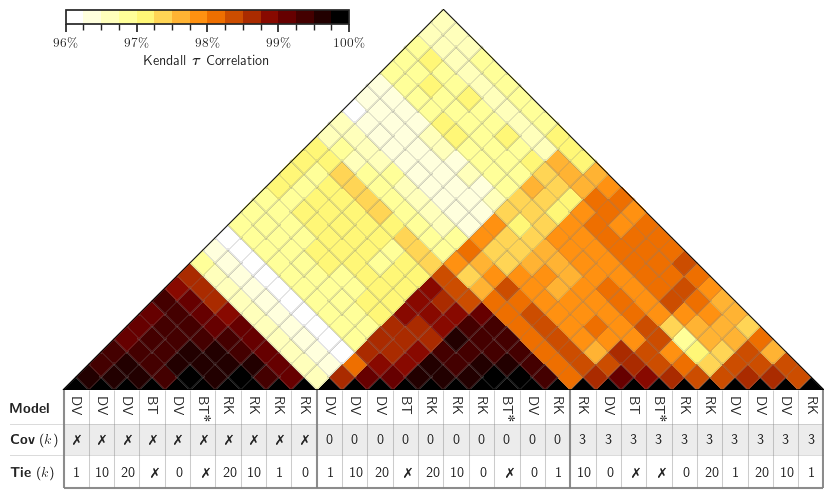

In [9]:
# fig, ax = plt.subplots(figsize=(14, 14))
fig = plt.figure(figsize=(10.5, 12))
gs = GridSpec(2, 1, height_ratios=[5, 1], hspace=-0.09)

ax_top = fig.add_subplot(gs[0])
ax_top.set_aspect(2.0)
ax_top.set_frame_on(False)  # Turn off the frame

method = 'average'
ordered_stat, indices = reorder(stat, method=method, convert_to_dist=True)

# indices = np.array([
#     4, 1, 7, 8, 9, 10, 19, 20, 21, 22,
#     6, 3, 15, 16, 17, 18, 27, 28, 29, 30,
#     5, 2, 11, 12, 13, 14, 23, 24, 25, 26,
# ]) - 1

# indices = np.r_[indices[:10], indices[20:], indices[10:20]]
#indices = np.r_[indices[:10], indices[10:20][::-1], indices[20:30]]
#indices = np.r_[indices[:10], indices[20:][::-1], indices[10:20][::-1]]


ordered_stat = stat[np.ix_(indices, indices)]
ordered_names = model_names[indices]

# with texplot.theme(rc=rc, use_latex=True):

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}


with texplot.theme(use_latex=True, font_scale=0.85):
    plt.rcParams.update(rc)

    cmap = plt.cm.afmhot_r
    
    X, Y, cb = cor_plot(fig, ax_top, ordered_stat, ordered_names, horizontal=True, cmap=cmap, use_weight=use_weight)
    
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
    ax_bottom.set_aspect(0.24)
    
    # Hide all tick marks and labels
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])
    
    # Hide axis frame
    ax_bottom.axis('off')
    
    # Invert the y-axis so that zero is at the boundary between the two axes
    ax_bottom.invert_yaxis()
    
    n = X.shape[0]
    epsilon = 0.003
    for i in range(n):
        x = 2.0*(X[i, i]+Y[i, i])
        if i == 0: x += epsilon
        if i == n-1: x -= epsilon
        if i % 10 == 0:
            linewidth = 1.5
            color = (0.5, 0.5, 0.5, 0.9)
        else:
            linewidth = 0.75
            color = (0.5, 0.5, 0.5, 0.4)
        ax_bottom.vlines(x, 0.27, 1.35, color=color, linewidth=linewidth)
    
    ax_bottom.text(-1.14, 0.52, r'\textbf{Model}')
    ax_bottom.text(-1.14, 0.87, r'\textbf{Cov} ($k$)')
    ax_bottom.text(-1.14, 1.23, r'\textbf{Tie} ($k$)')
    
    #ax_bottom.hlines(0.22, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.65, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.99, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(1.35, -1+epsilon, 1-epsilon, color=(0.5, 0.5, 0.5, 0.9), linewidth=1.5)
    #ax_bottom.vlines(-1.15, 0.22, 1.25, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    
    ax_bottom.add_patch(plt.Rectangle((-1+epsilon, 0.65), 2-2*epsilon, 0.99-0.65, facecolor=(0.5, 0.5, 0.5, 0.15),
                                      edgecolor='none', zorder=-1000))
    
    ax_bottom.set_xlim(left=-1.14)

    ax_bottom.set_zorder(0)
    ax_top.set_zorder(1)
    
    if use_weight:
        filename = 'kendall_weighted.pdf'
    else:
        filename = 'kendall.pdf'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    
    plt.show()

# Kendall with Dendrogram

In [10]:
# Extract the icoord, dcoord, color_list, and leaves
import copy

# This function plots dendrogram in certain order. Namely, it reverses interval [0, 9], [10,, 19]
# and [20, 29].
def plot_dendro(ax, dendro):

    icoord = copy.deepcopy(dendro['icoord'])
    dcoord = copy.deepcopy(dendro['dcoord'])
    color_list = copy.deepcopy(dendro['color_list'])
    leaves = copy.deepcopy(dendro['leaves'])
    
    def mirror_interval(group_start, group_end):
    
        # Reverse the x-coordinates for segments within the specified range
        for j in range(len(icoord)):
            for i in range(len(icoord[j])):
                if (group_start * 10  <= icoord[j][i]) and (icoord[j][i] <= group_end * 10 + 5):
                    icoord[j][i] = (1 + group_start) * 10 + ((group_end) * 10 - icoord[j][i])
    
    mirror_interval(0, 9)
    mirror_interval(10, 19)
    mirror_interval(20, 29)
    
    # Identify the top two highest levels in the hierarchy
    highest_level = len(icoord) - 1
    second_highest_level = len(icoord) - 2
    
    # Determine which side (left or right) of the highest level connects to the second-highest level
    if icoord[highest_level][0] in icoord[second_highest_level] or icoord[highest_level][1] in icoord[second_highest_level]:
        # Adjust the left side of the highest level
        icoord[highest_level][0] = (icoord[second_highest_level][0] + icoord[second_highest_level][3]) / 2
        icoord[highest_level][1] = icoord[highest_level][0]
    else:
        # Adjust the right side of the highest level
        icoord[highest_level][2] = (icoord[second_highest_level][0] + icoord[second_highest_level][3]) / 2
        icoord[highest_level][3] = icoord[highest_level][2]
    
    # Plot the modified dendrogram
    for i, (xs, ys) in enumerate(zip(icoord, dcoord)):
        ax.plot(xs, ys, color=color_list[i])

Bbox(x0=0.125, y0=0.3036702127659573, x1=0.9000000000000001, y1=0.6357724043343368)


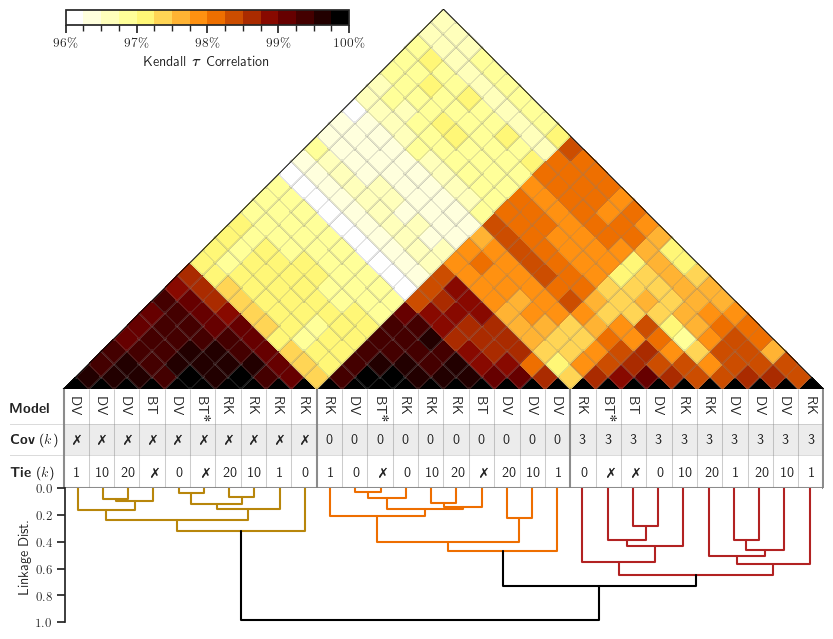

In [11]:
# Reorder stat matric using hierarchal clustering
method = 'weighted'
ordered_stat, indices = reorder(stat, method=method, convert_to_dist=True)

#indices = np.r_[indices[:10], indices[20:], indices[10:20]]
indices = np.r_[indices[:10][::-1], indices[10:20][::-1], indices[20:30][::-1]]

ordered_stat = stat[np.ix_(indices, indices)]
ordered_names = model_names[indices]

# Dendrogram's linkage
diag = np.diag(ordered_stat)
dist_matrix = 1.0 - ordered_stat / np.sqrt(np.outer(diag, diag))
dist_matrix_condensed = squareform(dist_matrix, checks=True)
custom_linkage = sch.linkage(dist_matrix_condensed, method=method)
custom_linkage = optimal_leaf_ordering(custom_linkage, dist_matrix_condensed)
custom_linkage[:, 2] = custom_linkage[:, 2] / (np.max(custom_linkage[:, 2] * 1.02))  # normelize linkage distance

# ========
# PLOTTING
# ========

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}

with texplot.theme(use_latex=True, font_scale=0.85):
    plt.rcParams.update(rc)

    fig = plt.figure(figsize=(10.5, 11.45))
    gs = GridSpec(3, 1, height_ratios=[5, 1, 1], hspace=-0.09)

    # ======
    # AX TOP
    # ======
    
    ax_top = fig.add_subplot(gs[0])
    ax_top.set_aspect(2.0)
    ax_top.set_frame_on(False)  # Turn off the frame

    cmap = plt.cm.afmhot_r
    
    X, Y, cb = cor_plot(fig, ax_top, ordered_stat, ordered_names, horizontal=True, cmap=cmap, use_weight=use_weight)
    
    # =========
    # AX BOTTOM
    # =========
    
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
    ax_bottom.set_aspect(0.24)
    
    # Hide all tick marks and labels
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])
    
    # Hide axis frame
    ax_bottom.axis('off')
    
    # Invert the y-axis so that zero is at the boundary between the two axes
    ax_bottom.invert_yaxis()
    
    n = X.shape[0]
    epsilon = 0.003
    for i in range(n):
        x = 2.0*(X[i, i]+Y[i, i])
        if i == 0: x += epsilon
        if i == n-1: x -= epsilon
        if i % 10 == 0:
            linewidth = 1.5
            color = (0.5, 0.5, 0.5, 0.9)
        else:
            linewidth = 0.75
            color = (0.5, 0.5, 0.5, 0.4)
        ax_bottom.vlines(x, 0.27, 1.35, color=color, linewidth=linewidth, zorder=10)
    
    ax_bottom.text(-1.14, 0.52, r'\textbf{Model}')
    ax_bottom.text(-1.14, 0.87, r'\textbf{Cov} ($k$)')
    ax_bottom.text(-1.14, 1.23, r'\textbf{Tie} ($k$)')
    
    #ax_bottom.hlines(0.22, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.65, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.99, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(1.35, -1+epsilon, 1-epsilon, color=(0.5, 0.5, 0.5, 0.9), linewidth=1.5)
    #ax_bottom.vlines(-1.15, 0.22, 1.25, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)

    ax_bottom.add_patch(plt.Rectangle((-1+epsilon, 0.65), 2-2*epsilon, 0.99-0.65,
                                      facecolor=(0.5, 0.5, 0.5, 0.15),
                                      edgecolor='none', zorder=-10))
    
    ax_bottom.set_xlim(left=-1.14)

    ax_bottom.set_zorder(0)
    ax_top.set_zorder(1)

    # =========
    # AX DENDRO
    # =========

    ax_dendro = fig.add_subplot(gs[2]) #, sharex=ax_top)
    # ax_dendro.set_aspect(0.24)
    
    # # Hide all tick marks and labels
    # ax_dendro.set_xticks([])
    # ax_dendro.set_yticks([])

    # # Hide axis frame
    #ax_dendro.axis('off')
    ax_dendro.spines['top'].set_visible(False)
    ax_dendro.spines['right'].set_visible(False)
    ax_dendro.spines['bottom'].set_visible(False)
    ax_dendro.spines['left'].set_visible(True)  # Keep only the left spine (y-axis)
    ax_dendro.get_xaxis().set_visible(False)

    colors = ['darkgoldenrod', 'chocolate', 'firebrick']
    #colors = ['darkgoldenrod', '#af5819', 'firebrick']
    #colors = ['darkgoldenrod', '#C24C00', 'maroon']
    #colors = ['darkgoldenrod', '#C24C00', 'firebrick']
    colors = ['darkgoldenrod', '#EE6E00', 'firebrick']
    sch.set_link_color_palette(colors)
    threshold = 0.7
    dendro = sch.dendrogram(custom_linkage, no_plot=True, 
                            orientation='bottom', no_labels=True, color_threshold=threshold, 
                            show_contracted=True, above_threshold_color='black',
                            ax=ax_dendro)
    plot_dendro(ax_dendro, dendro)

    pos_top = ax_top.get_position()  # Get the position of ax_top
    pos_dendro = ax_dendro.get_position()  # Get the position of ax_dendro
    
    # Set the width of ax_dendro to match ax_top's width
    # ax_dendro.set_position([pos_top.x0, pos_dendro.y0, pos_top.width,
    #                         pos_dendro.height])
    ax_dendro.set_position([0.1775, pos_dendro.y0-0.0097, 0.721,
                            pos_dendro.height])

    # ax_dendro.set_ylim([2e-3, 2e-1])
    # ax_dendro.set_ylim(top=0.14, bottom=1.01)
    # ax_dendro.set_yscale('log')
    # min_y = np.min(custom_linkage[:, 2])
    # max_y = np.max(custom_linkage[:, 2])
    # rng_y = max_y - min_y
    # ax_dendro.set_ylim([min_y - 0.05 * rng_y, max_y + 0.01 * rng_y])
    # ax_dendro.set_ylim([min_y / 1.2, max_y *1.05])
    ax_dendro.set_xlim([0, 10 * dist_matrix.shape[0]])
    ax_dendro.set_ylim([0, 1])
    # ax_dendro.set_ylim([2e-2, 1e0 * 1.04])
    ax_dendro.invert_yaxis()
    ax_dendro.set_ylabel('Linkage Dist.')
    ax_dendro.tick_params(axis='y', labelsize=9)
    ax_dendro.yaxis.labelpad = 3
    
    # max_height = custom_linkage[:, 2].max()
    # ax_dendro.set_ylim(bottom=max_height + 3e-3)

    cb.ax.set_position([0.178, 0.2346, 0.27, 0.4])
    
    if use_weight:
        filename = 'kendall_weighted_dendrogram.pdf'
    else:
        filename = 'kendall_dendrogram.pdf'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()